In [2]:
try: 
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns
try:
    import pymc as pm # For MCMC
except:
    !pip install pymc
    import pymc as pm
try:
    import arviz as az # For MCMC package
except:
    !pip install arviz
    import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
try:
    import corner
except:
    !pip install corner
    import corner

print(pm.__version__)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.15.0


In [11]:
def dfg(a,b):
    file_path = 'datasets/Donor%d_CD%d_Genes.csv' %(a,b)
    all_df = pd.read_csv(file_path)
    file_path = 'datasets/mt_genes_metadata.csv'
    dfmeta = pd.read_csv(file_path)
    protein_coding_genes = dfmeta[dfmeta['gene_type'] == 'protein_coding']
    protein_names = protein_coding_genes['gene_name'].tolist()
    df2 = pd.DataFrame([all_df[i] for i in protein_names]).T
    return df2

In [12]:
def normiz_2(df,s_n = 1000):
    df1 = df
    listfinal = [sum(df.iloc[i]) for i in range(len(df))]
    for i in range(len(df)):
        df1.iloc[i] = df1.iloc[i]/listfinal[i] * s_n
    return df1

In [18]:
def lse(a,b):
    x = g_log(normiz_2(dfg(a,b)))[0]
    y = g_log(normiz_2(dfg(a,b)))[1]

    X = np.vstack([np.ones(len(x)), x]).T
    # theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    a, b = theta
    print(f"Estimated parameters: a = {a}, b = {b}")

    y_pred = a + b * x

    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)

    print(f"R-squared (R^2) value: {r_squared}")
    plt.figure(figsize=(8,8))
    plt.scatter(x, y, label='Observed data')
    plt.plot(x, y_pred, color='red', label='Fitted line')
    plt.xlabel('log(mean)')
    plt.ylabel('log(var)')
    plt.title('Least Squares Estimation of normalised data')
    plt.legend()
    plt.show()

In [14]:
def g_log(df_n):
    df_final = normiz_2(df_n).T
    gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
    gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
    log_gene_mean = np.log(gene_mean)
    log_gene_var = np.log(gene_var)
    return log_gene_mean, log_gene_var

def log_gene_plot(df_n):
    df_final = normiz_2(df_n).T
    gene_mean = [np.mean(df_final.iloc[i]) for i in range(13)]
    gene_var = [np.var(df_final.iloc[i]) for i in range(13)]
    log_gene_mean = np.log(gene_mean)
    log_gene_var = np.log(gene_var)
    plt.scatter(log_gene_mean,log_gene_var)

In [15]:
def linfitplot(x,y):
    linear_model = pm.Model()
# Define the PyMC model
    with linear_model:
        # Priors for unknown parameters
        a_prior = pm.Normal('a', mu=0, sigma=10)
        b_prior = pm.Normal('b', mu=0, sigma=10)
        sigma_prior = pm.HalfNormal('sigma', sigma=2)

        # Expected value of outcome
        mu = a_prior * x + b_prior

        # Likelihood (sampling distribution) of observations
        vals = pm.Normal('vals', mu=mu, sigma=sigma_prior, observed=y)
        
        step = pm.Slice()
        tracel = pm.sample(1000, step=step, return_inferencedata=True)
        ppc_samples = pm.sample_posterior_predictive(tracel)
    
    ppc_vals = np.asarray(ppc_samples["posterior_predictive"].vals)
    
    for y_i in ppc_vals[0]:
        plt.plot(x,y_i,alpha=0.1,color="pink")
    
    plt.plot(x,y,"ko",label="Data")
    plt.legend()
    plt.xlabel("x")
    plt.xlabel("y")

def lse_general(x,y):
    X = np.vstack([np.ones(len(x)), x]).T
    # theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    a, b = theta
    print(f"Estimated parameters: a = {a}, b = {b}")

    y_pred = a + b * x

    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)

    print(f"R-squared (R^2) value: {r_squared}")
    plt.figure(figsize=(8,8))

    plt.scatter(x, y, label='Observed data',s= 1)
    plt.plot(x, y_pred, color='red', label='Fitted line')
    
    plt.xlabel('MT-CO1')
    plt.ylabel('MT-CO2')
    plt.title('Linear fit between MT-CO1 and MT-CO2')
    plt.legend()
    plt.show()

c:\Users\ruizc\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Pairplot of MT-CO1,MT-CO2,MT-CO3')

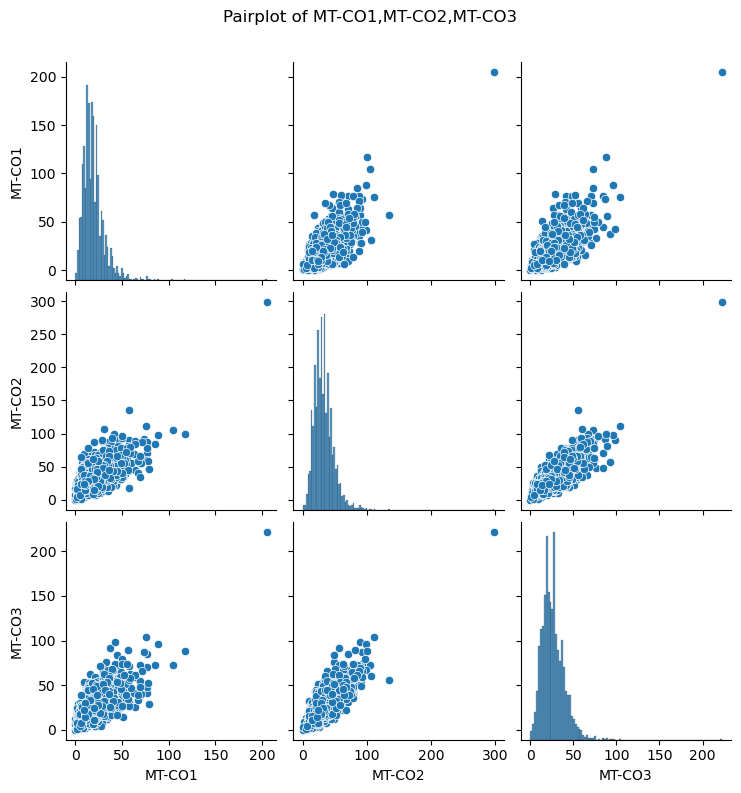

In [16]:
df1 = pd.DataFrame(dfg(1,4),columns=['MT-CO1','MT-CO2','MT-CO3'])
g= sns.pairplot(df1)
g.fig.suptitle("Pairplot of MT-CO1,MT-CO2,MT-CO3",y = 1.05)

Estimated parameters: a = 16.71967287814771, b = 0.8241328943641942
R-squared (R^2) value: 0.39226606328996305


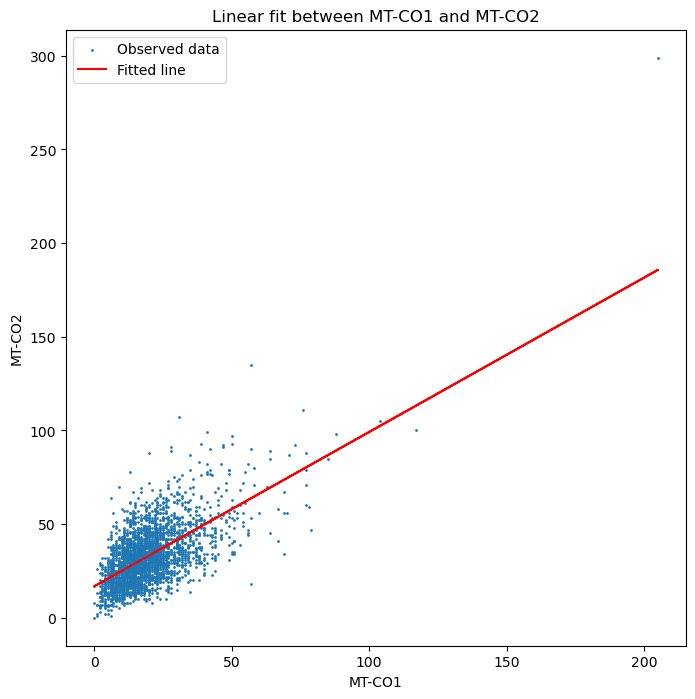

In [64]:
x = dfg(1,4)['MT-CO1']
y = dfg(1,4)['MT-CO2']
lse_general(x,y)



In [37]:
dfg(1,4)

MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP8  MT-ATP6  MT-CO3  MT-ND3  \
0         12       3      23      53       34        3      38       6   
1          8       4      24      35       10        2      34       3   
2          7       2      16      30        8        1      19       6   
3          3       2      25      23       14        5      23       2   
4          6       3       6      26       14        1      11       4   
...      ...     ...     ...     ...      ...      ...     ...     ...   
2883       4       0      20      15       11        3      11       2   
2884       2       5      13      28       12        2      18       6   
2885       5       0      10      22       13        1      14       4   
2886       6      12      36      45       19        2      40       5   
2887       7       1       9      24       11        0      22       1   

      MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  
0          20       5       7       7      20  
1          15       7       6       1      17  
2          20       3       7       0      15  
3          13       4       6       3      14  
4          14       0       2       0       7  
...       ...     ...     ...     ...     ...  
2883        5       2       3       0       4  
2884       14       2       2       1       8  
2885        6       7       5       1      20  
2886       20       8       7       0      37  
2887        7       2       7       1      17  

[2888 rows x 13 columns]

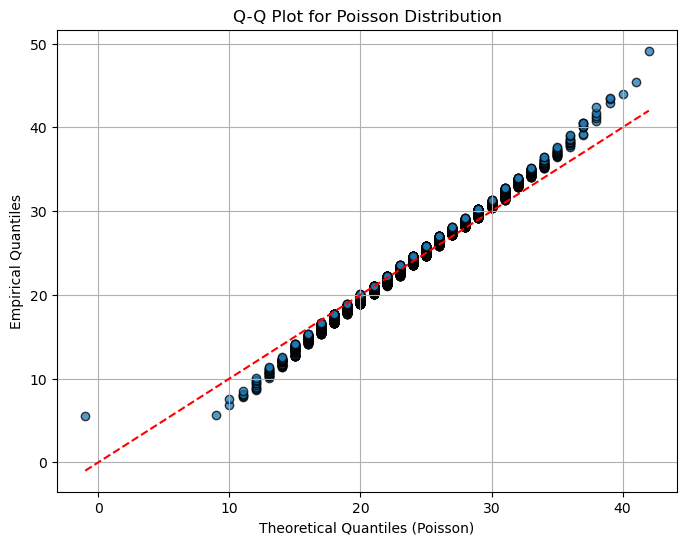

In [51]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Example gene expression data (replace with your data)
data = normiz_2(dfg(1,4),1000/(np.e ** 1.9340102220340734))
df = pd.DataFrame(data)

# Select the gene of interest
gene_expression = df['MT-CO3']

# Estimate lambda (mean of the gene expression)
lambda_est = np.mean(gene_expression)

# Generate theoretical quantiles for the Poisson distribution
theoretical_quantiles = stats.poisson.ppf(
    np.linspace(0, 1, len(gene_expression)), mu=lambda_est)

# Sort the empirical gene expression data
empirical_quantiles = np.sort(gene_expression)

# Create the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, empirical_quantiles, edgecolor='k', alpha=0.75)
plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles (Poisson)')
plt.ylabel('Empirical Quantiles')
plt.title('Q-Q Plot for Poisson Distribution')
plt.grid(True)
plt.show()


Estimated parameters: a = 1.9340102220340734, b = 1.0993566989318007
R-squared (R^2) value: 0.9670751161979677


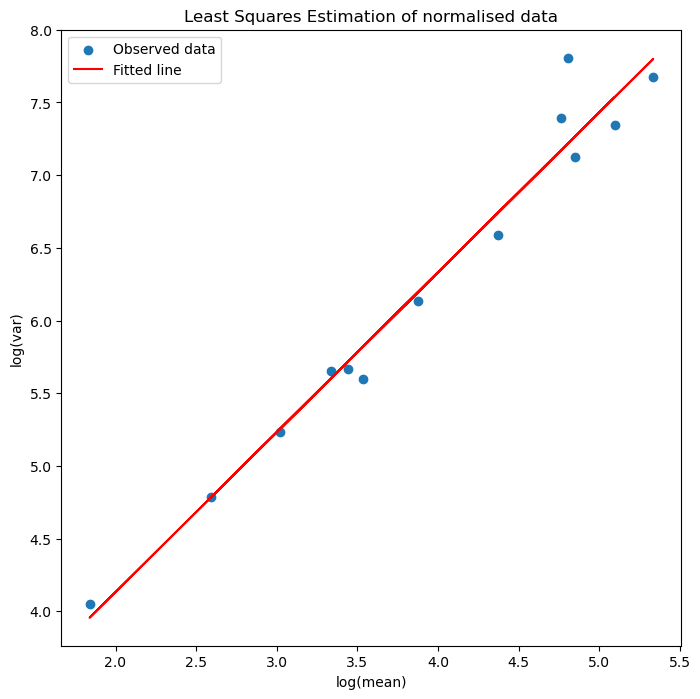

In [19]:
lse(1,4)

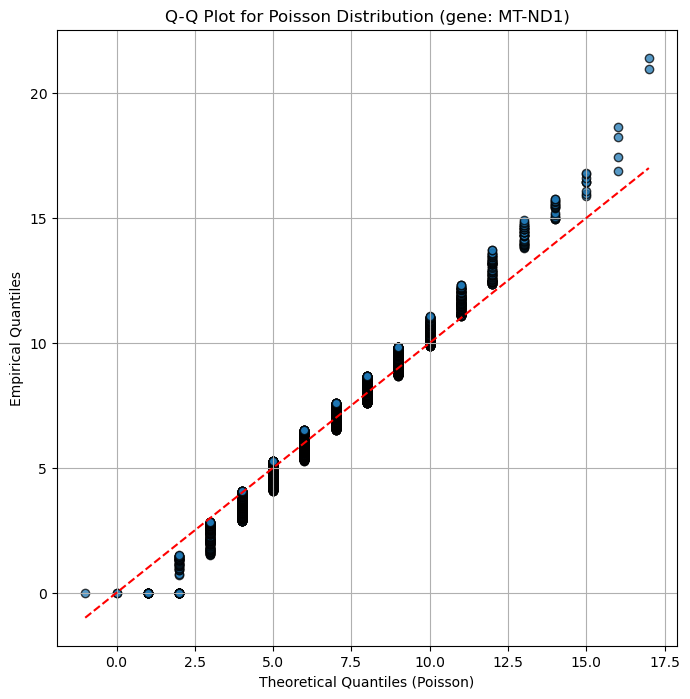

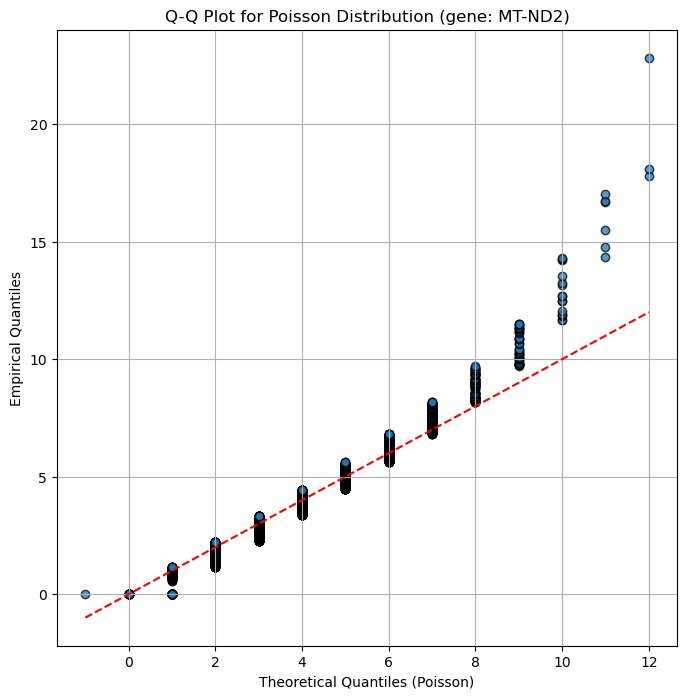

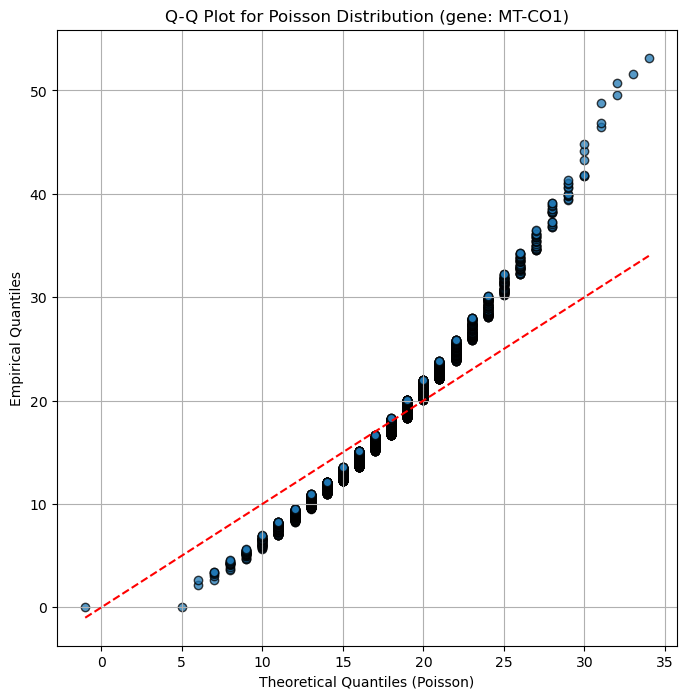

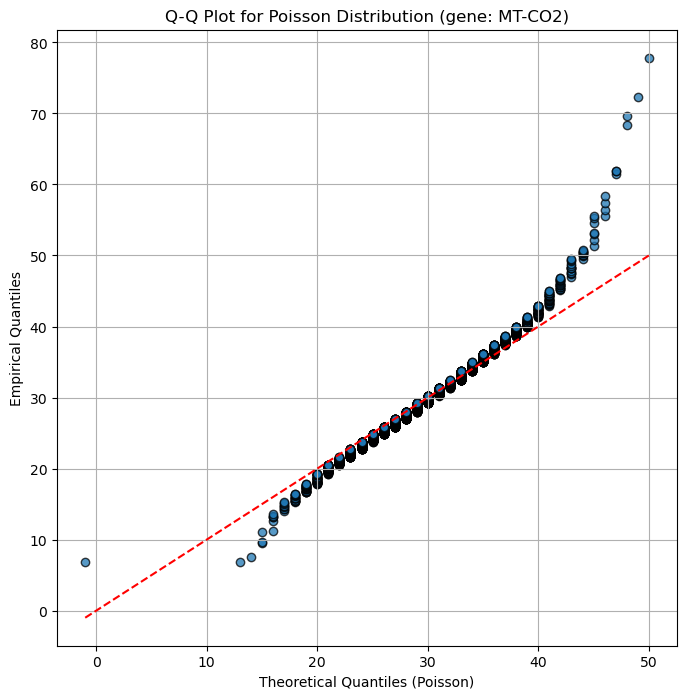

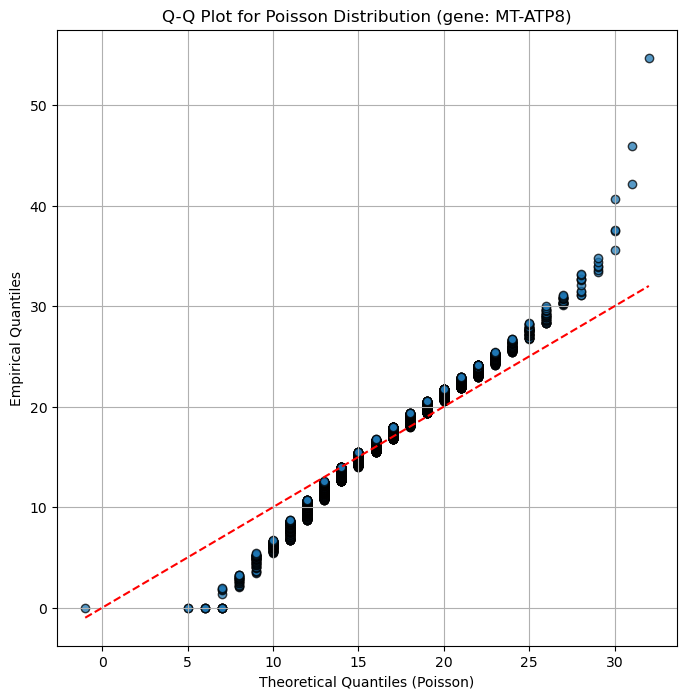

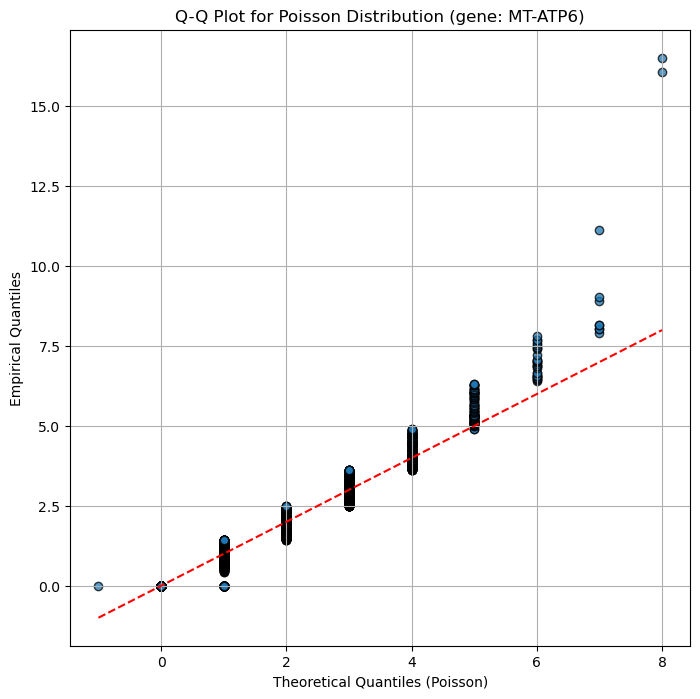

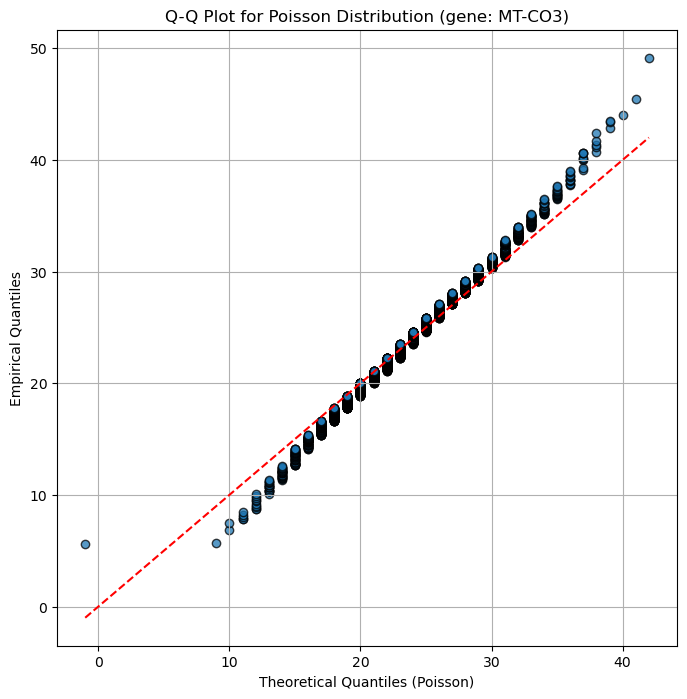

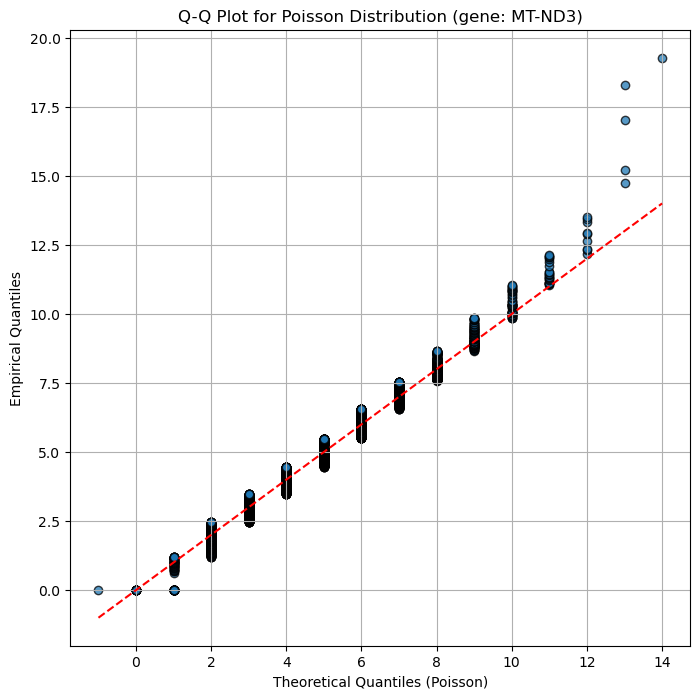

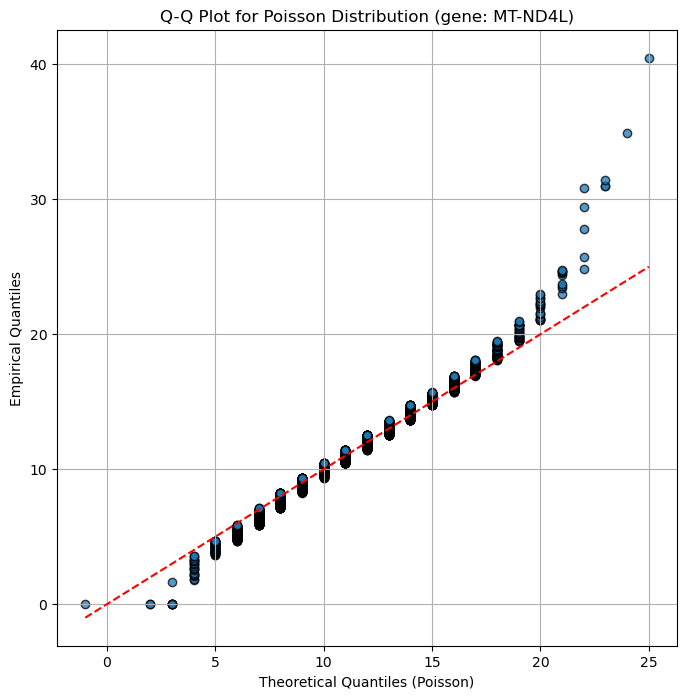

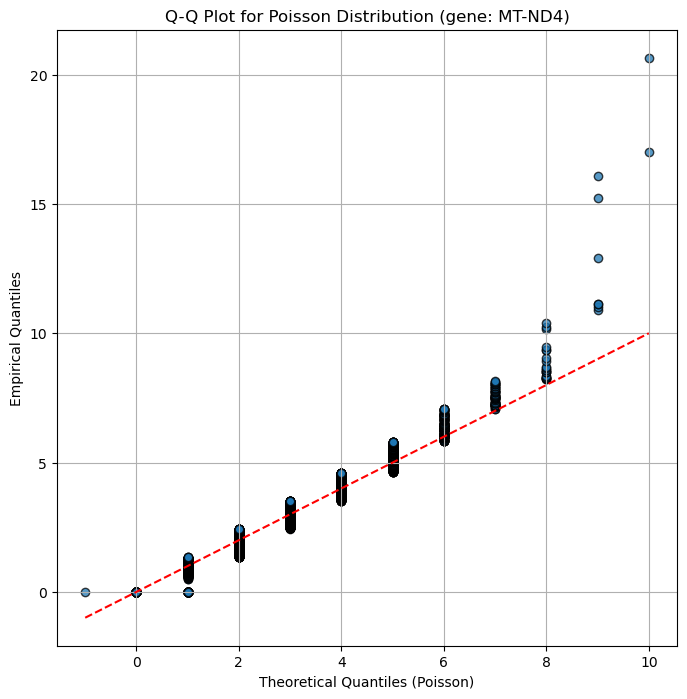

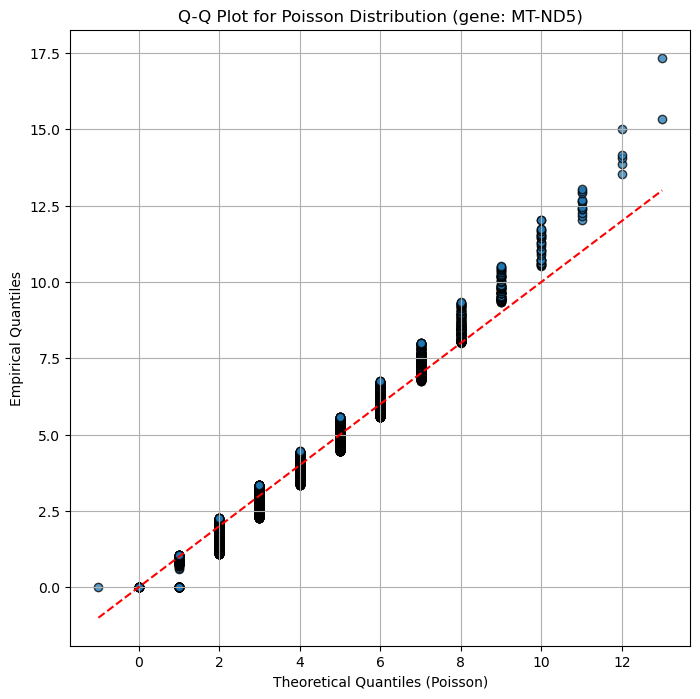

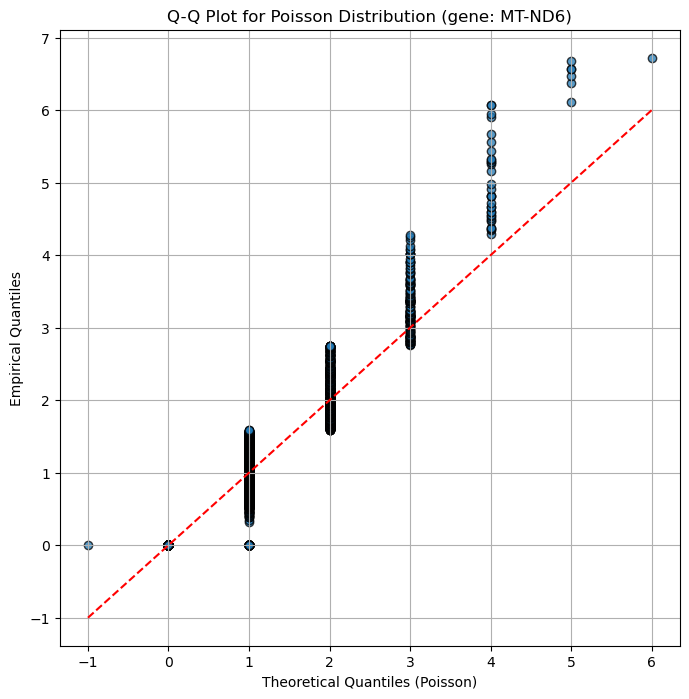

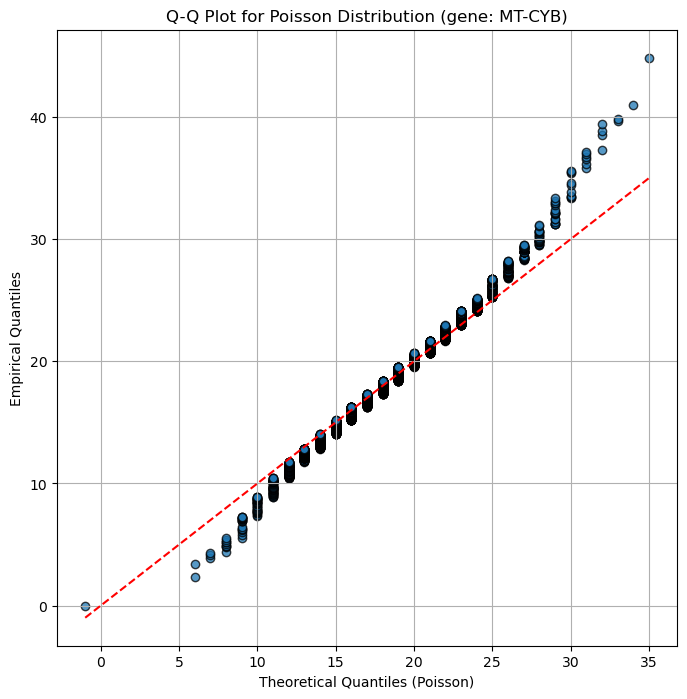

In [61]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Example gene expression data (replace with your data)
data = normiz_2(dfg(1,4),1000/(np.e ** 1.9340102220340734))
df = pd.DataFrame(data)
for i in df.columns:
# Select the gene of interest
    gene_expression = df[i]

    # Estimate lambda (mean of the gene expression)
    lambda_est = np.mean(gene_expression)

    # Generate theoretical quantiles for the Poisson distribution
    theoretical_quantiles = stats.poisson.ppf(
        np.linspace(0, 1, len(gene_expression)), mu=lambda_est)

    # Sort the empirical gene expression data
    empirical_quantiles = np.sort(gene_expression)

    # Create the Q-Q plot
    plt.figure(figsize=(8, 8))
    plt.scatter(theoretical_quantiles, empirical_quantiles, edgecolor='k', alpha=0.75)
    plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--')
    
    plt.xlabel('Theoretical Quantiles (Poisson)')
    plt.ylabel('Empirical Quantiles')
    plt.title('Q-Q Plot for Poisson Distribution (gene: %s)' %(i))
    output_path = 'Q-Q_Plot_gene_%s.png' %(i) # You can change the file name and format here
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
    plt.grid(True)
    plt.show()
    

Estimated parameters: a = 1.934010222034055, b = 1.099356698931805
R-squared (R^2) value: 0.9670751161979677


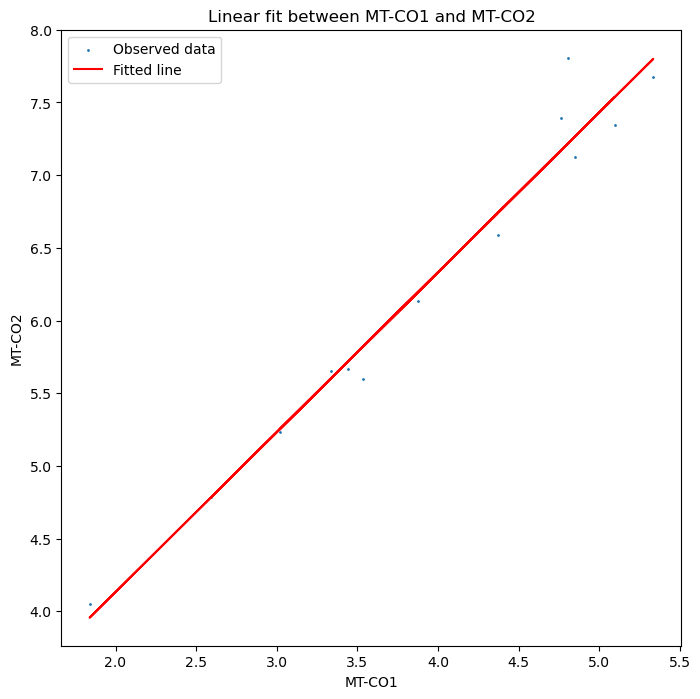

In [58]:
data = normiz_2(dfg(1,4),1000/(np.e ** 1.9340102220340734))
x = g_log(data)[0]
y = g_log(data)[1]
lse_general(x,y)

Estimated parameters: a = nan, b = nan
R-squared (R^2) value: 1.0


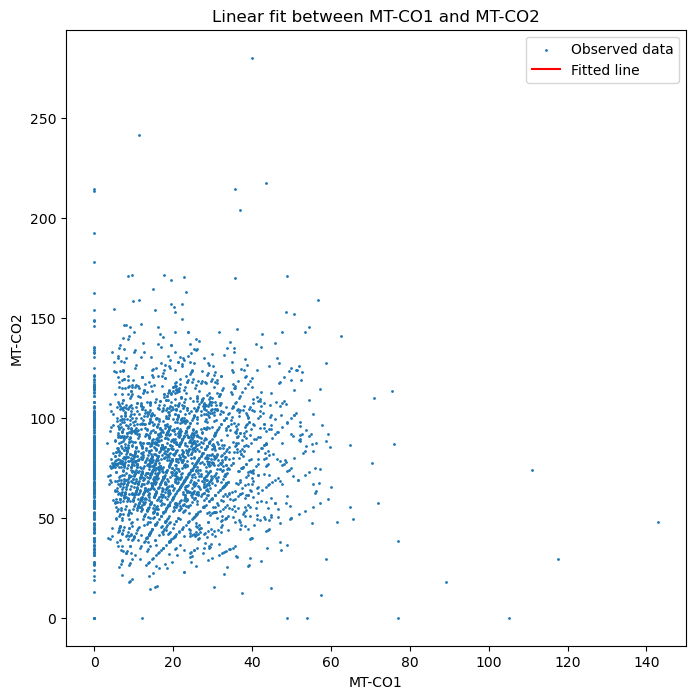

In [66]:
x = normiz_2(dfg(1,4))['MT-ND4']
y = normiz_2(dfg(1,4))['MT-ND4L']
lse_general(x,y)


c:\Users\ruizc\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


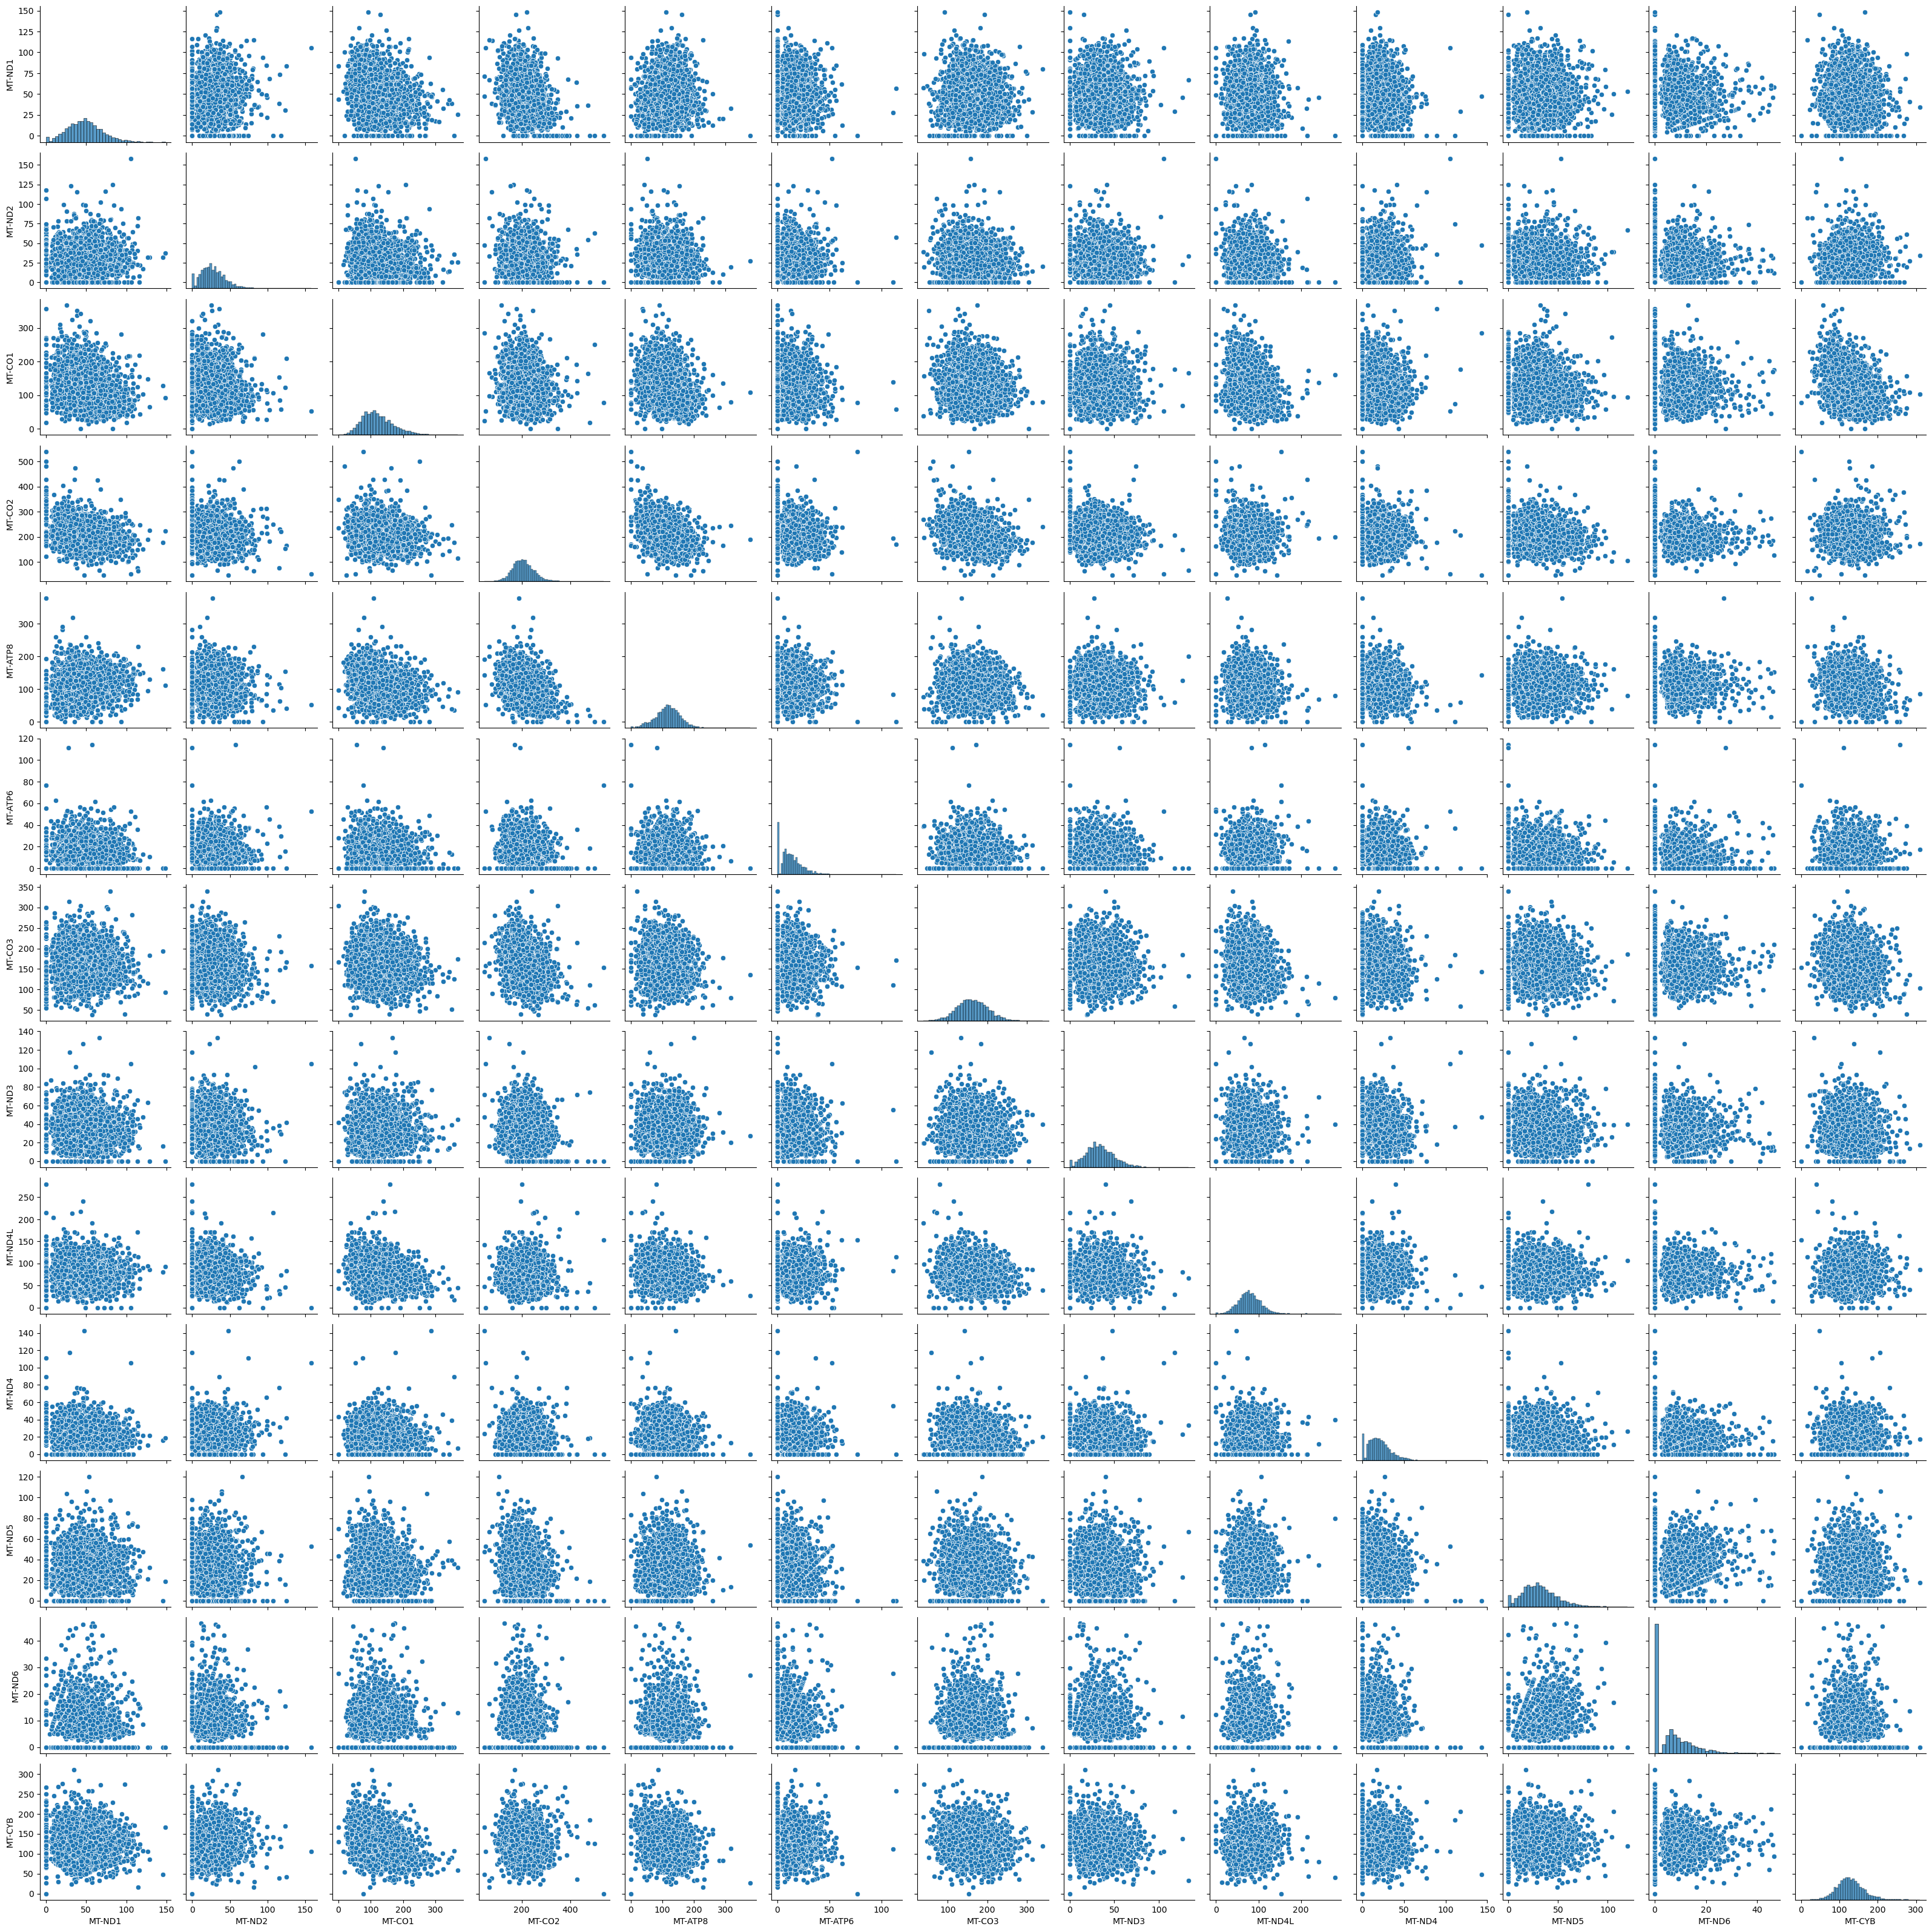

In [67]:
sns.pairplot(normiz_2(dfg(1,4)))

In [9]:
import numpy as np
import scipy.stats as stats
import numpy as np
import scipy.stats as stats

def poisson_goodness_of_fit(data, alpha=0.05):
    """
    Performs a goodness-of-fit test to check if the data follows a Poisson distribution.

    Parameters:
    - data (array-like): The observed data to test.
    - alpha (float): The significance level for the test (default is 0.05).

    Returns:
    - chi2_statistic (float): The Chi-square test statistic.
    - p_value (float): The p-value of the test.
    - conclusion (str): Conclusion whether to reject or not reject the null hypothesis.
    """
    # Estimate the Poisson parameter (lambda)
    lambda_est = np.mean(data)
    
    # Get the observed frequencies
    observed_freq, bins = np.histogram(data, bins=np.arange(data.min(), data.max() + 2) - 0.5)
    
    # Compute the expected frequencies using the Poisson distribution
    expected_freq = len(data) * stats.poisson.pmf(bins[:-1], mu=lambda_est)
    
    # Perform the Chi-square test
    chi2_statistic, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Determine if we reject the null hypothesis
    conclusion = 'Reject' if p_value < alpha else 'Do not reject'
    
    return chi2_statistic, p_value, conclusion




def poisson_goodness_of_fit_nonint(data, alpha=0.05, min_exp_count=1):
    """
    Performs a goodness-of-fit test to check if the data follows a Poisson distribution.

    Parameters:
    - data (array-like): The observed data to test.
    - alpha (float): The significance level for the test (default is 0.05).
    - min_exp_count (int): The minimum expected count for a bin to avoid low frequency issues.

    Returns:
    - chi2_statistic (float): The Chi-square test statistic.
    - p_value (float): The p-value of the test.
    - conclusion (str): Conclusion whether to reject or not reject the null hypothesis.
    """
    # Round the non-integer data to the nearest integers
    rounded_data = np.round(data).astype(int)

    # Perform the chi-square goodness-of-fit test for the rounded data
    chi2_stat, p_value, conclusion = poisson_goodness_of_fit(rounded_data, alpha)
    
    return chi2_stat, p_value, conclusion

# Example usage
np.random.seed(42)
data = np.random.exponential(scale=2, size=100)  # Generate non-integer data

chi2_stat, p_val, result = poisson_goodness_of_fit_nonint(data)
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"p-value: {p_val}")
print(f"Conclusion: {result} the null hypothesis that data follows a Poisson distribution.")


c:\Users\ruizc\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8042: RuntimeWarning: divide by zero encountered in scalar divide
  relative_diff = (np.abs(f_obs_sum - f_exp_sum) /


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
inf

In [10]:
import numpy as np
from scipy.stats import poisson, chisquare

# Sample non-integer data
data = [2.3, 3.5, 1.7, 4.2, 2.8, 3.1, 2.9, 4.5, 3.7, 3.3]

# Estimate lambda (mean of data)
lambda_est = np.mean(data)

# Define bins
bins = [1, 2, 3, 4, 5]

# Calculate observed frequencies
observed_counts, _ = np.histogram(data, bins=bins)
print(f"Observed counts: {observed_counts}")

# Calculate expected frequencies for each bin using the Poisson PMF
total_count = len(data)
expected_probs = [poisson.pmf(k, lambda_est) for k in range(len(bins)-1)]
expected_counts = np.array(expected_probs) * total_count
print(f"Expected counts: {expected_counts}")

# Perform the Chi-square goodness of fit test
chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)
print(f"Chi-square Statistic: {chi2_stat}, p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: The data does not follow a Poisson distribution.")
else:
    print("Fail to reject the null hypothesis: The data follows a Poisson distribution.")


Observed counts: [1 3 4 2]
Expected counts: [0.40762204 1.30439053 2.08702484 2.22615983]


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.6596967028533297

In [7]:
len(dfg(2,4))

4034

In [8]:
dfg(2,4)

MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP8  MT-ATP6  MT-CO3  MT-ND3  \
0         15      11      23      34       26        2      26      15   
1         11       9      16      41       25        4      16      14   
2          5       0       6      14       14        3      13       9   
3         13       4      10      40       26        0      17      14   
4         14       6      28      30       27        1      29      21   
...      ...     ...     ...     ...      ...      ...     ...     ...   
4029       9       3      18      18       14        1      20      14   
4030      14       4      24      21       11        1      27      11   
4031      12       6       7      23       21        2      22      17   
4032      13       7      11      17        9        2      24       9   
4033       9       2      11      12       11        4      15       9   

      MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  
0          15       2       9       3      25  
1          13       3       8       6      17  
2           5       5       1       0      11  
3          21       4       6       2      25  
4          14      11      13       6      29  
...       ...     ...     ...     ...     ...  
4029       11      11       7       0      15  
4030       13       5       4       0      21  
4031       10       4       4       0      29  
4032        9       2       4       2      16  
4033        3       2       4       0       8  

[4034 rows x 13 columns]